# Predicting Resale Condominium Apartment Prices in the Greater Toronto Area

## 1. Introduction

My [last project](https://app.powerbi.com/view?r=eyJrIjoiNzMxZTliYmUtYzI3My00NjZkLTlkM2MtOGEyYWYzMDRmMzI5IiwidCI6Ijg2MGEzN2E4LTJjODEtNDk1Mi04ZWQwLTk5MmFjNTFlMmJkZiIsImMiOjN9) provided a broad overview of the resale real estate market in the Greater Toronto Area (GTA) and helped to visualize what was going on in terms of pricing and supply. This project pivots to a more fine-grained level and looks at individual condominium apartment listings, with the goal of building a price predictor using machine learning models.

![Condos](2_Analysis/architecture-buildings-business-374870.jpg)

### i. Background and Methodology

Condo listings data was scraped using Scrapy from a third-party listings website in October 2018. It's important to note that it's common practice for boutique or luxury condo buildings to be exclusively listed by certain brokerages. These higher-end listings may not be posted publicly, and thus are not captured in the data.

As the real estate dashboard from my previous project showed, sale price growth accelerated between 2012 and 2017, so prices before 2017 would not necessarily aid our model. Also, to maintain data purity, we don't necessarily want listings with a 'terminated' or 'expired' status - just listings that have sold as our target variable is sold price. As such, this project wittles down our sample size to almost 44,000 sold listings, transacted between January 2017 and October 2018.

Listings data provides crucial information such as size range and number of bedrooms. However, I was curious about pricing's relationship with other data points, such as building age and size. I also wanted to see the influence of proximity to higher-order transit. For the purposes of this project, I define this as subway stations, streetcar stops, GO train stations, and Bus Rapid Transit (BRT)\* stops. Using Open Data portals (and General Transit Feed Specification data to fill in gaps for tricky streetcar stops data) and with a bit of wrangling in QGIS and database joining, I included variables for four features: distance to nearest BRT stop, nearest Subway or Streetcar stop, nearest GO train, and overall nearest higher-order transit stop (i.e. the closest of the three).

\* _includes three routes with dedicated right-of-ways: York Region VIVA BRT on Davis Drive, York Region Highway 7 East BRT, and Mississauga MiWay (dedicated ROW route only)._

Other variables I've included are the presence of certain amenities (e.g. pool, gym, party room), total amenities, and municipality. A full list will follow shortly.


### ii. Before we dive in...

I should note that the bulk of this post, particularly at the beginning, will be on the data cleaning/preprocessing and encoding. Real estate data (at least in the GTA) is more often than not incomplete and "dirty", sometimes unusable. However, with certain data parsing methods, we can fill in these gaps.

An example of this would be listings with missing size range information. However, instead of throwing these datapoints in the recycling bin, using regular expressions, size data can be extracted from listings descriptions, wherein realtors would describe the unit and sometimes mention its square footage. Same goes for number of bedrooms. So from these descriptions, I have parsed out size and number of bedrooms into **Size_Description** and ** Beds_Description** fields, respectively.

Other things worth noting:
- Certain columns like "Amenities" are binary-encoded (i.e. 1 = True, 0 = False)
- In our dataframes, "nan" is Pythonic for "not a number" and indicates missing data

In [1]:
# Libraries to load
import time
import json
import random
import os
import csv
import re

import pandas as pd
import numpy as np

from collections import Counter

# For graphing
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Display options
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option("display.max_columns", 50)

In [2]:
# Load and view a sample of the data
with open("output_resale_2018-10-31_clean.csv", 'r') as f:
    resales_df = pd.read_csv(f, index_col = False)
resales_df.sample(20)

,Amenities__Gym / Exercise Room,Amenities__Party Room,Amenities__Pool,Balcony,Bath,Beds,Beds_Description,Building_Reg_Date,Building_Completion,Building_Storeys,Building_Units,Days on Market,Den_Description,Locker,Muni,Nearest_BRT,Nearest_GO,Nearest_HOT,Nearest_SS,Parking,Size_Description,Size_Range,Sold Price,Unit
33132,1,1,0,Open,2.0000,2,2.0000,2016-10-28,nan,11,367,6.0000,0,Owned,toronto,21243.2845,2120.2162,118.1565,118.1565,Yes,0,700-799,665000.0000,N1006
15484,1,1,1,Open,2.0000,2+1,nan,2017-01-13,nan,23,399,0.0000,1,Owned,toronto,17052.9692,4936.1694,80.3128,80.3128,Yes,NaN,1200-1399,1315000.0000,1417
30261,1,1,1,Open,1.0000,1+1,nan,2011-04-29,nan,41,435,7.0000,0,No,toronto,8630.8855,731.5015,731.5015,1333.2279,Yes,0,600-699,356000.0000,2607
11908,1,0,1,None,2.0000,2,2.0000,2002-01-22,nan,8,64,36.0000,0,Owned,mississauga,886.2491,3057.7813,886.2491,14714.0617,Yes,0,800-899,290000.0000,104
9558,1,1,1,Open,1.0000,1+1,1.0000,2012-04-18,nan,28,1131,60.0000,1,Owned,toronto,8298.3440,858.1979,157.1629,157.1629,Yes,739,700-799,460000.0000,1206
5808,1,1,1,None,2.0000,3,3.0000,1990-11-12,nan,24,235,5.0000,0,Owned,brampton,12494.3652,3358.3294,3358.3294,17843.2611,Yes,0,1400-1599,430000.0000,210
417,1,0,1,Open,1.0000,2,2.0000,2015-12-02,nan,11,96,44.0000,0,Owned,toronto,21135.7993,1159.5990,94.7533,94.7533,Yes,NaN,800-899,685000.0000,403
43739,1,1,1,None,2.0000,2+1,2.0000,1981-03-04,nan,24,230,20.0000,0,Ensuite,toronto,6036.0944,1616.6446,1616.6446,2195.5561,Yes,"1,711",1600-1799,675000.0000,307
5601,1,1,0,Open,2.0000,NaN,2.0000,2014-07-21,nan,4,125,16.0000,0,No,brampton,17509.3515,241.7032,241.7032,23755.3748,Yes,0,unknown,415000.0000,301
16240,0,0,0,Open,1.0000,2,nan,2005-10-11,nan,4,48,0.0000,0,Exclusive,burlington,19593.0060,3142.5288,3142.5288,31575.4287,Yes,0,800-899,375000.0000,212


### Remove Parking, Locker, and Wine Cellar Listings
As mentioned, real estate listings are highly nuanced and require a lot of cleaning. In our scraped data, there are listings for parking spots, lockers, and even wine cellars! These are less than $10,000 - a price threshold which no condo listing falls under (through a separate, manual exploration). So let's remove them from our data.

In [3]:
resales_df = resales_df[resales_df['Sold Price'] > 10000]
resales_df.reset_index(drop=True, inplace=True)

### How much data is useful / useless?

In [4]:
resales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43941 entries, 0 to 43940
Data columns (total 24 columns):
Amenities__Gym / Exercise Room    43941 non-null int64
Amenities__Party Room             43941 non-null int64
Amenities__Pool                   43941 non-null int64
Balcony                           43941 non-null object
Bath                              43917 non-null float64
Beds                              42482 non-null object
Beds_Description                  27084 non-null float64
Building_Reg_Date                 43753 non-null object
Building_Completion               61 non-null float64
Building_Storeys                  43941 non-null int64
Building_Units                    43941 non-null int64
Days on Market                    43931 non-null float64
Den_Description                   43941 non-null int64
Locker                            43941 non-null object
Muni                              43941 non-null object
Nearest_BRT                       43941 non-null float64

As you can quickly see above, of the 43,941 listings, almost all fields have values. 

It's worth pointing on that the most incomplete field is **Building_Completion**, for which only 61 listings have values. Although there is next to no information for this field, we will retain this as it will help us fill in gaps in **Building_Reg_Date** later.

From the sample we can also see there are a handful of 'unknown' string values, which are essentially nulls. We will need to replace them with an actual null value understood by our model: _NaN_, which stands for Not a Number. After some cleaning, we can visualize how much data we are actually missing.

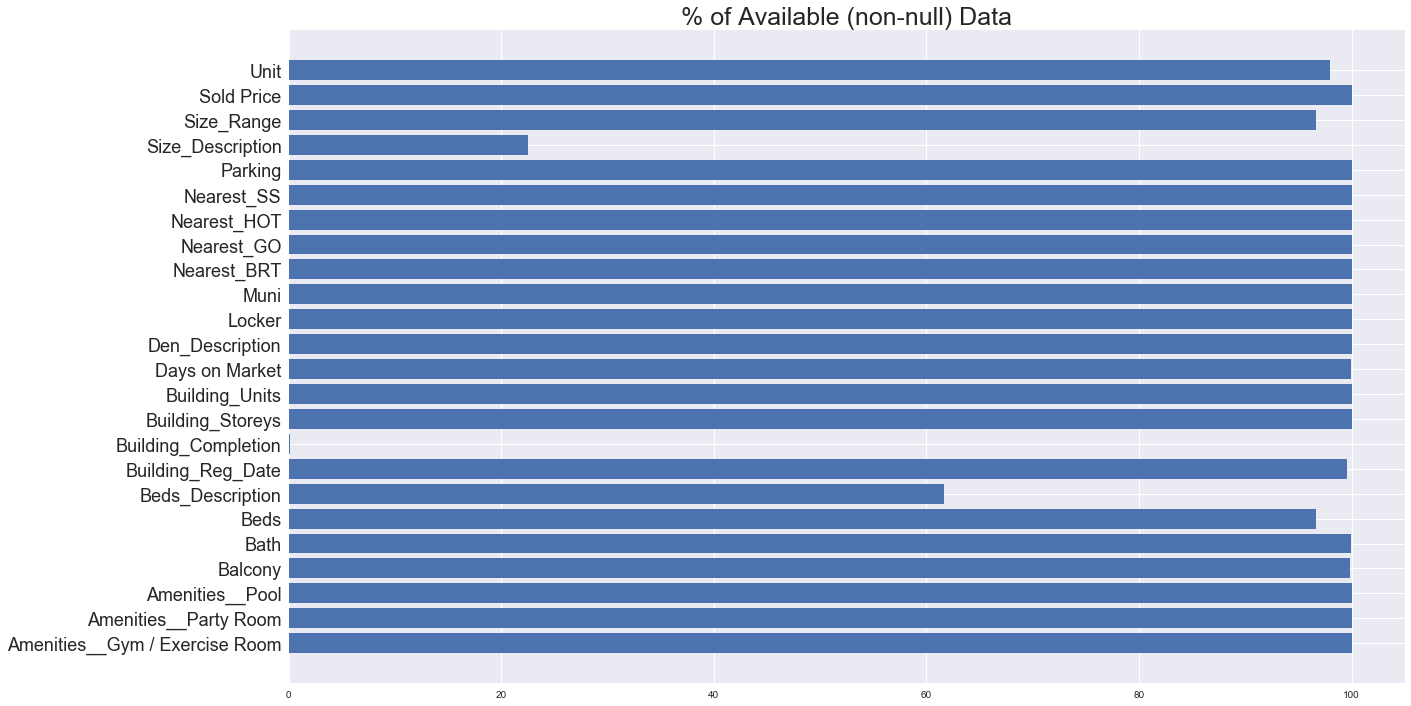

In [5]:
# Replace null or unknown values with np.nan
resales_df['Balcony'].replace("Unknown", np.nan, inplace=True)
resales_df['Size_Range'].replace("unknown", np.nan, inplace=True)
resales_df['Size_Description'] = resales_df['Size_Description'].str.replace(",", "").replace("0",np.nan).replace("",np.nan).astype(float)

# Visualize missing data:
variables = resales_df.columns
count = []
for var in variables:
    notnull = resales_df[var].count()
    count.append(notnull)
count_pct = np.round(pd.Series(count) * 100 / len(resales_df), 2)

# Plot
plt.figure(figsize=(20,12))
plt.barh(width = count_pct, y = range(len(variables)))
plt.yticks(range(len(variables)), variables, fontsize = 18)
plt.title('% of Available (non-null) Data', fontsize=25)
plt.show()

Exploring our data a bit further, if we were to use only rows without nulls, how many rows would we have? Let's omit **Size Description, Beds Description, Building_Completion** as they have the most nulls.

In [6]:
no_nulls = resales_df.drop(['Size_Description', 'Beds_Description','Building_Completion'], axis=1).dropna()
print("From an original {:,} listings, there are {:,} listings (or {:.2f}%) that have no nulls at all.".format(\
    len(resales_df), len(no_nulls), len(no_nulls)/len(resales_df)*100))

From an original 43,941 listings, there are 42,028 listings (or 95.65%) that have no nulls at all.


For the remaining percentage of listings that have null data, we can either drop them or impute data to fill them in. We'll do this in the following section where we'll simultaneously encode our data. 

## 2. Encoding Fields:
##### 1. Size_Range / Size_Description
##### 2. Sold_Price 
##### 3. Balcony
##### 4. Municipality
##### 5. Building_Storeys
##### 6. Building_Units
##### 7. Building_Reg_Date
##### 8. Beds_Description vs. Beds
##### 9. Baths
##### 10. Days on Market
##### 11. Nearest Higher-Order Transit Stop
##### 12. Parking
##### 13. Lockers
##### 14. Unit (Construct two new binary features: Is_TH, Is_PH)

---


### 2.1 Size_Range / Size_Description

Assuming that size is a very important predictor of price, we would like to retain as much **Size_Range** info as possible. Are there any rows that have **Size_Description** info extracted but no **Size_Range** info which we could fill in?

In [7]:
sizes = resales_df[resales_df['Size_Range'].isnull()]['Size_Description'].notnull()

print("There are {} listings that do not have Size_Range but have sizes from Size Description.".format(sum(sizes)))

There are 286 listings that do not have Size_Range but have sizes from Size Description.


Our machines won't understand that "500-599" is a range of sizes smaller than "1800-1999". To assign meaning and hierarchy to this, we will map size ranges into easily understandable levels from 1 (0-499 sq. ft.) ... to 24 (5,000 sq ft. +).

In [8]:
# First we build a function that will help us encode unit sizes into size range level.
def codify_sizes(input_size):
    # Note this is for individual sizes, not ranges.
    input_size = float(input_size)
### Conversion 
    if input_size < 250:
        size_range = 0
        # probably parking or locker...
    elif input_size <= 499:
        size_range = 1
    elif input_size <= 599:
        size_range = 2
    elif input_size <= 699:
        size_range = 3
    elif input_size <= 799:
        size_range = 4
    elif input_size <= 899:
        size_range = 5
    elif input_size <= 999:
        size_range = 6
    elif input_size <= 1199:
        size_range = 7
    elif input_size <= 1399:
        size_range = 8
    elif input_size <= 1599:
        size_range = 9
    elif input_size <= 1799:
        size_range = 10
    elif input_size <= 1999:
        size_range = 11
    elif input_size <= 2249:
        size_range = 12
    elif input_size <= 2499:
        size_range = 13
    elif input_size <= 2749:
        size_range = 14
    elif input_size <= 2999:
        size_range = 15
    elif input_size <= 3249:
        size_range = 16
    elif input_size <= 3499:
        size_range = 17
    elif input_size <= 3749:
        size_range = 18
    elif input_size <= 3999:
        size_range = 19
    elif input_size <= 4249:
        size_range = 20
    elif input_size <= 4499:
        size_range = 21
    elif input_size <= 4749:
        size_range = 22
    elif input_size <= 4999:
        size_range = 23
    elif input_size >= 5000:
        size_range = 24
    else:
        print("input size is not a number, please check.")
        
    return size_range

    

# Now we build a function that encodes size ranges into size range level
def codify_size_range(input_range):
    input_range = str(input_range)
    range_dict = {'0-499': 1, '500-599': 2, '600-699': 3,'700-799': 4,'800-899': 5,
                  '900-999': 6,'1000-1199': 7,'1200-1399': 8,'1400-1599': 9,
                  '1600-1799': 10,'1800-1999': 11,'2000-2249': 12,'2250-2499': 13,
                  '2500-2749': 14,'2750-2999': 15,'3000-3249': 16,'3250-3499': 17,
                  '3500-3749': 18,'3750-3999': 19,'4000-4249': 20,'4250-449': 21,
                  '4500-4749': 22,'4750-4999': 23, '5000 +': 24, 'nan': np.nan}
    if input_range in range_dict:
        x = range_dict[input_range]
    else:
        start_range = re.findall('^[0-9]*',input_range)[0]
        end_range = re.findall('[0-9]*$',input_range)[0]
        med = (int(start_range) + int(end_range)) / 2
        x = codify_sizes(med)
    return x

Now we run the function on each listing.

In [9]:
# Refactor Size_Range so that they fall into their factor levels.
resales_df['Size_Range'] = [codify_size_range(i) for i in resales_df['Size_Range']]

# Fill null Size_Range with size descriptions
replace_rows = resales_df['Size_Range'].isnull() & resales_df['Size_Description'].notnull()
resales_df.loc[replace_rows,'Size_Range'] = [codify_sizes(i) for i in resales_df.loc[replace_rows, 'Size_Description']]

resales_df.drop('Size_Description', axis=1, inplace=True)

# Drop Where Size Range is null.
len_before = sum(resales_df['Size_Range'].isnull())
resales_df.dropna(subset = ['Size_Range'], axis = 0, inplace = True)
print("{:,} listings were dropped for not having size_range data. New number of listings is {:,}.".format(len_before, len(resales_df)))

# Reset Index
resales_df.reset_index(drop = True, inplace = True)

1,174 listings were dropped for not having size_range data. New number of listings is 42,767.


### 2.2 Sold Price
This is our target variable! Let's explore its distribution in our data.

In [10]:
resales_df['Sold Price'].describe()

count      42767.0000
mean      538109.4844
std       300302.1524
min        89500.0000
25%       390000.0000
50%       470000.0000
75%       600000.0000
max     11500000.0000
Name: Sold Price, dtype: float64

C:\Users\Fabienne\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


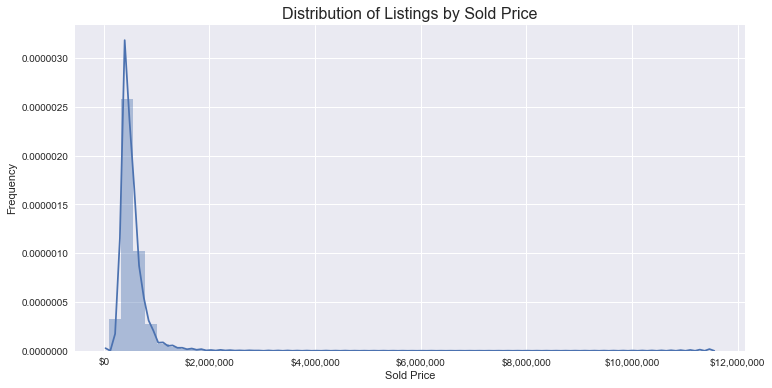

In [11]:
fig = plt.figure(figsize=(12,6))
plt.title("Distribution of Listings by Sold Price", fontsize = 16)
plt.ylabel('Frequency')
ax = sns.distplot(resales_df['Sold Price'])
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

plt.show()

As we can see from the distribution, luxury units (up to \$12 million! ) are skewing our distribution to the right. Depending on what model we use, this could be a problem. For visualization purposes, let's temporarily omit listings over $2 million as these are less common.

C:\Users\Fabienne\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


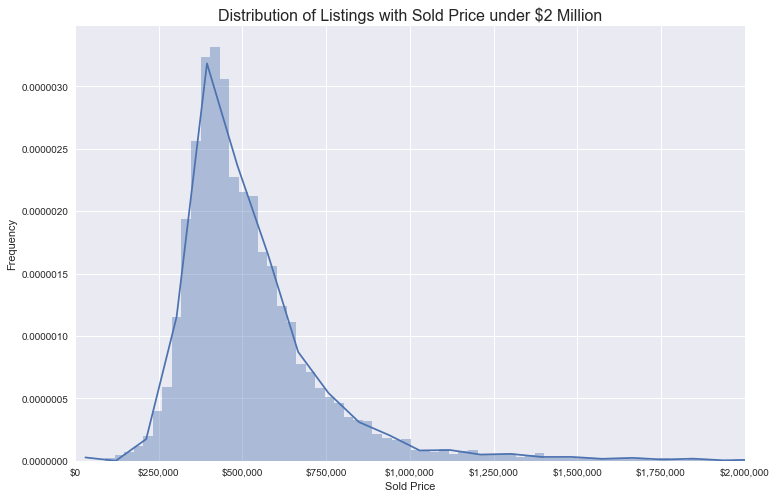

In [12]:
fig = plt.figure(figsize=(12,8))
plt.title("Distribution of Listings with Sold Price under $2 Million", fontsize = 16)
plt.ylabel('Frequency')
ax = sns.distplot(resales_df['Sold Price'], bins = 400)
plt.xlim(0,2000000)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.show()

This looks about right - listings typically hover between \$300,000 to \$600,000.

### 2.3 Balcony
We're going to One-Hot encode our Balcony data. We can't factor into levels like we did with size ranges because the data isn't orginal. If 'Open Balcony' was 1 and 'Juliette Balcony' was 2, it doesn't mean Juliettes are "bigger" or "better" than Open balconies. Thus we'll use One-Hot Encoding to create fields for each balcony type, with 0 indicating if it isn't that type, and 1 if it is.

In [13]:
Counter(resales_df['Balcony'])

Counter({'Open': 29602,
         'None': 6897,
         'Terrace': 4009,
         'Juliette': 976,
         'Enclosed': 1280,
         nan: 3})

Given that there are just 3 missing 'Balcony' values, we can avoid removing the entire observation and instead replace it with the most common observation, 'Open'.

In [14]:
resales_df.loc[resales_df['Balcony'].isnull(), 'Balcony'] = 'Open'

In [15]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Data Scaler
from sklearn.preprocessing import StandardScaler

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(resales_df['Balcony'])

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

one_hot_labels = ['Balcony_'+i for i in label_encoder.classes_]
one_hot_balcony = pd.DataFrame(onehot_encoded, columns = one_hot_labels)


# Delete the old columns
resales_df = resales_df.drop('Balcony', axis = 1)

# Add the new One-Hot encoded columns
resales_df = pd.concat([resales_df, one_hot_balcony], axis = 1)

resales_df.sample(6)

,Amenities__Gym / Exercise Room,Amenities__Party Room,Amenities__Pool,Bath,Beds,Beds_Description,Building_Reg_Date,Building_Completion,Building_Storeys,Building_Units,Days on Market,Den_Description,Locker,Muni,Nearest_BRT,Nearest_GO,Nearest_HOT,Nearest_SS,Parking,Size_Range,Sold Price,Unit,Balcony_Enclosed,Balcony_Juliette,Balcony_None,Balcony_Open,Balcony_Terrace
36529,1,0,0,1.0000,1,1.0000,2001-06-27,nan,18,91,0.0000,0,Exclusive,toronto,18770.7014,3104.1265,112.9149,112.9149,Yes,3.0000,480000.0000,1507,0.0000,1.0000,0.0000,0.0000,0.0000
2154,1,0,1,1.0000,2+1,nan,1971-06-12,nan,26,897,10.0000,1,Exclusive,toronto,4086.6102,1280.5084,1280.5084,6110.9569,Yes,7.0000,260000.0000,2101,0.0000,0.0000,0.0000,1.0000,0.0000
1006,1,0,0,1.0000,1+1,1.0000,1980-09-11,nan,5,41,2.0000,1,Ensuite,toronto,18782.0425,3413.9517,319.8708,319.8708,Yes,5.0000,480000.0000,505,0.0000,0.0000,0.0000,1.0000,0.0000
26239,1,1,0,1.0000,1+1,nan,2009-04-28,nan,24,207,12.0000,0,Owned,toronto,5347.7286,1185.6612,367.8915,367.8915,Yes,3.0000,375000.0000,1204,0.0000,0.0000,0.0000,1.0000,0.0000
13322,1,1,1,2.0000,2,nan,2005-05-12,nan,31,398,17.0000,0,Common,toronto,7150.1683,3762.7534,566.6894,566.6894,Yes,6.0000,639000.0000,1411,0.0000,0.0000,0.0000,1.0000,0.0000
30794,1,1,0,1.0000,1+1,1.0000,2015-09-28,nan,20,257,0.0000,1,No,toronto,8427.3220,747.9461,264.3569,264.3569,Yes,3.0000,435000.0000,716,0.0000,0.0000,0.0000,1.0000,0.0000


### 2.4 Municipality (One-Hot Encoding)
Repeat the One-Hot encoding process for "Municipality" field.

In [16]:
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(resales_df['Muni'])

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

one_hot_muni = pd.DataFrame(onehot_encoded, columns = label_encoder.classes_)

# Delete the old columns
resales_df = resales_df.drop('Muni', axis = 1)

# Add the new One-Hot encoded columns
resales_df = pd.concat([resales_df, one_hot_muni], axis = 1)

resales_df.sample(6)

,Amenities__Gym / Exercise Room,Amenities__Party Room,Amenities__Pool,Bath,Beds,Beds_Description,Building_Reg_Date,Building_Completion,Building_Storeys,Building_Units,Days on Market,Den_Description,Locker,Nearest_BRT,Nearest_GO,Nearest_HOT,Nearest_SS,Parking,Size_Range,Sold Price,Unit,Balcony_Enclosed,Balcony_Juliette,Balcony_None,Balcony_Open,Balcony_Terrace,ajax,aurora,brampton,burlington,markham,milton,mississauga,newmarket,oakville,oshawa,pickering,richmondhill,toronto,vaughan,whitby
9305,1,1,0,1.0000,1,1.0000,2002-07-19,nan,9,183,7.0000,0,Owned,13700.6722,6437.4584,6437.4584,13595.3183,Yes,1.0000,228800.0000,405,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
20251,1,1,1,2.0000,2,2.0000,2013-01-10,nan,18,196,19.0000,0,Owned,1172.9507,2638.1298,1172.9507,14261.3812,Yes,5.0000,490000.0000,PH3,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
13757,1,1,1,2.0000,2+1,nan,2006-05-01,nan,37,597,0.0000,1,Owned,16148.7624,977.7859,195.0677,195.0677,Yes,6.0000,883000.0000,3001,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
162,0,0,0,2.0000,2,nan,1987-01-29,nan,19,300,7.0000,0,Ensuite,8939.8232,5366.6140,4476.7771,4476.7771,Yes,7.0000,300000.0000,1705,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
16658,1,0,1,1.0000,1,nan,2015-04-30,nan,57,591,29.0000,0,No,21693.4626,379.3190,234.0668,234.0668,Yes,2.0000,585600.0000,5209,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
33655,1,0,0,2.0000,2+1,2.0000,1999-05-12,nan,6,110,38.0000,1,Exclusive,15433.2876,3817.2039,3025.8908,3025.8908,Yes,8.0000,355000.0000,305,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


### 2.5 Building Storeys
Factor building storeys into four ordinal categories: "Low-rise", "Mid-Rise", "High-Rise", and "Very Tall":

    Low-Rise = <6
    Mid-Rise = 6 to 11 storeys (per City of Toronto guidelines)
    High-Rise = 12 to 49 storeys
    Very Tall = 50+

In [17]:
def codify_storeys(x):
    x = float(x)
    if x is np.nan:
        y = np.nan
    elif x < 6:
        y = 0
    elif x < 12:
        y = 1
    elif x < 50:
        y = 2
    elif x >= 50:
        y = 3
    else:
        print("Input is not a number.")
    return y

resales_df['Building_Storeys'] = [codify_storeys(i) for i in resales_df['Building_Storeys']]

### 2.6 Building_Units
Without getting too much into the technical details, we'll standardize building_units using a log transformation so that the data is centered around a mean. This will help us overcome the effects of outliers and highlight the relationship between building size (by units) for our model.

C:\Users\Fabienne\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


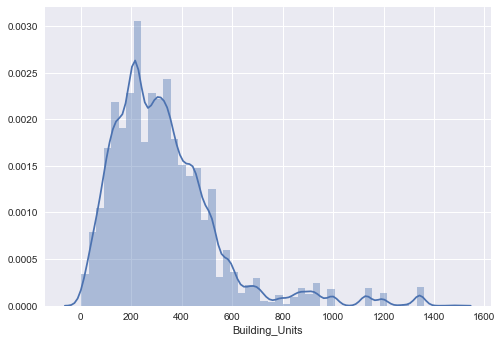

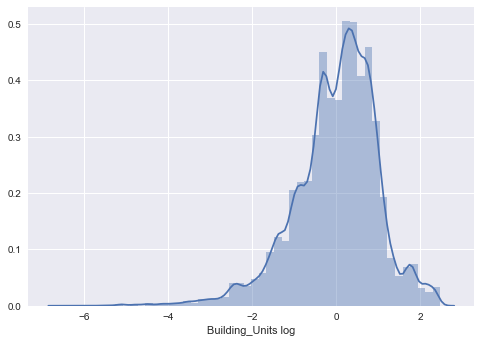

In [18]:
# Let's visualize the difference without log and with log.
plt.clf()
sns.distplot(resales_df['Building_Units'])
plt.show()

resales_df['Building_Units log'] = StandardScaler().fit_transform(np.log(resales_df['Building_Units']).values.reshape(-1,1))
sns.distplot(resales_df['Building_Units log'])
plt.show()

In [19]:
resales_df['Building_Units'] = resales_df['Building_Units log']
resales_df.drop('Building_Units log', axis =1, inplace=True)

### 2.7 Building Registration Date (Building Age)
Here we interpret the registration date of buildings as the building age. While this may not necessarily be the case for all buildings (certain condo developers are notorious for delaying registering despite being completed a while ago), most builders would register upon completing construction as units are not legally allowed to be sold otherwise.

So let's create a **Building_Age** field using the **Building_Reg_Date** field. As mentioned at the beginning of this post, where buildings have no Registration Date, if it has an Expected Completion date, substitute NaN in **Building_Age** with '-1'. 

In [20]:
def building_age(x):
    if x is np.nan:
        return np.nan
    else:
        year = re.findall('[0-9]{4}', x)[0]
        year = int(year)
        return(2018-year)

resales_df['Building_Age'] = [building_age(i) for i in resales_df['Building_Reg_Date']]

# # If Building has expected completion date, put "-1" for Building Age
resales_df.loc[resales_df['Building_Age'].isnull(), 'Building_Age'] = [int(-1) if str(i) != 'nan' else np.nan for i in resales_df.loc[resales_df['Building_Age'].isnull(), 'Building_Completion']]

print("Median age of buildings is {} years. We'll replace {} missing building_ages with this.".format(resales_df['Building_Age'].median(), sum(resales_df['Building_Age'].isnull())))

resales_df.loc[resales_df['Building_Age'].isnull(), 'Building_Age'] = resales_df['Building_Age'].median()

# Drop columns
resales_df.drop(["Building_Completion", "Building_Reg_Date"], axis = 1, inplace = True)

Median age of buildings is 10.0 years. We'll replace 126 missing building_ages with this.


### 2.8 Beds, Beds_Description, Den_Description
One way to assure that "Beds" are not incorrectly entered by realtors is to compare them with the number of bathrooms. (e.g if there are Bath == 3 and Beds == 0, it is unlikely that this is a studio, and we must look to Beds_Description.).

We must also do the basic cleaning and replace full words with integers. Studio is 0, 1 Bedroom is 1, 1 Bed+Den is 1.5, etc.

In [21]:
def clean_beds(row):
    baths = row['Bath']
    beds = row['Beds']
    beds_description = row['Beds_Description']
    den_description = row['Den_Description']
    
    if '+' in str(beds):
        new_den = 0.5
    else:
        new_den = 0
    
    if 'Studio' in str(beds):
        new_beds = 0
    elif str(beds) != 'nan':        

        new_beds = re.findall('^[0-9]{1}',beds)[0]
        new_beds = int(new_beds)

        # Test for accuracy of "Beds" field. Use Beds_Description if more baths than beds.
        if str(baths) != 'nan':
            if new_beds == 0 & int(baths) > 1:
                if beds_description is not np.nan:
                    new_beds = beds_description
                else:
                    new_beds = 0
            if not new_den:
                new_den = den_description
        elif str(baths) == 'nan':
            new_beds = int(beds)
    
    elif str(beds) == 'nan':
        new_beds = float(beds_description)
        new_den = float(den_description)
    
    
    try:
        bed_type = new_beds + new_den
    except:
        bed_type = np.nan
        
    return bed_type

bed_type = []
for row in range(len(resales_df)):
    bed_type.append(clean_beds(resales_df.loc[row,:]))

resales_df['Bedrooms'] = bed_type

print('{:,} listings do not have "Beds" values. Clean_Beds function reduced \
this number down to {:,}.'.format(sum(resales_df['Beds'].isnull()), sum(pd.Series(bed_type).isnull())))

# Drop columns
resales_df.drop(['Beds', 'Den_Description', 'Beds_Description'], axis = 1, inplace = True)

# Drop Null Bedrooms
resales_df.dropna(subset = ['Bedrooms'], axis = 0, inplace = True)

# Reset Index
resales_df.reset_index(drop=True, inplace = True)

resales_df.sample(20)

286 listings do not have "Beds" values. Clean_Beds function reduced this number down to 90.


,Amenities__Gym / Exercise Room,Amenities__Party Room,Amenities__Pool,Bath,Building_Storeys,Building_Units,Days on Market,Locker,Nearest_BRT,Nearest_GO,Nearest_HOT,Nearest_SS,Parking,Size_Range,Sold Price,Unit,Balcony_Enclosed,Balcony_Juliette,Balcony_None,Balcony_Open,Balcony_Terrace,ajax,aurora,brampton,burlington,markham,milton,mississauga,newmarket,oakville,oshawa,pickering,richmondhill,toronto,vaughan,whitby,Building_Age,Bedrooms
10776,1,1,1,2.0000,2,0.5202,26.0000,Owned,9825.7275,2928.2639,823.1426,823.1426,Yes,5.0000,415000.0000,3207,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,14.0000,2.0000
13764,1,1,1,1.0000,2,1.1652,5.0000,Owned,16148.7624,977.7859,195.0677,195.0677,Yes,3.0000,568000.0000,1210,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,12.0000,1.5000
5492,1,1,0,1.0000,0,-1.1069,35.0000,Exclusive,17509.3515,241.7032,241.7032,23755.3748,Yes,4.0000,368000.0000,212,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,1.5000
37882,1,1,1,2.0000,2,0.6121,0.0000,Owned,15219.6669,1482.6786,56.7803,56.7803,Yes,4.0000,685000.0000,Ph1417,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,2.0000,1.0000
25355,1,0,1,3.0000,2,0.1893,61.0000,Owned,22116.9982,635.0858,364.0511,364.0511,Yes,13.0000,2375000.0000,Ph1204,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,2.0000,2.5000
33926,1,1,1,1.0000,1,-0.2528,16.0000,Owned,12469.6962,3213.2505,3213.2505,4282.8939,Yes,3.0000,427000.0000,524,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,13.0000,1.5000
29512,1,1,1,2.0000,2,0.7641,2.0000,No,8664.9045,784.8128,784.8128,1298.6625,Yes,6.0000,396000.0000,3024,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,7.0000,2.5000
29667,1,1,1,2.0000,2,0.2269,21.0000,Owned,9555.6852,1435.3865,284.7194,284.7194,Yes,5.0000,560000.0000,NaN,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,6.0000,2.5000
22037,1,1,1,1.0000,2,0.9895,10.0000,Owned,8540.6337,1645.8164,292.6288,292.6288,Yes,3.0000,390000.0000,307,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,15.0000,1.0000
37887,1,1,1,1.0000,2,0.6121,7.0000,No,15219.6669,1482.6786,56.7803,56.7803,No,2.0000,488000.0000,1006,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,2.0000,1.0000


At this point, it's worth doing a quick visualization of what our pricing data looks like. 

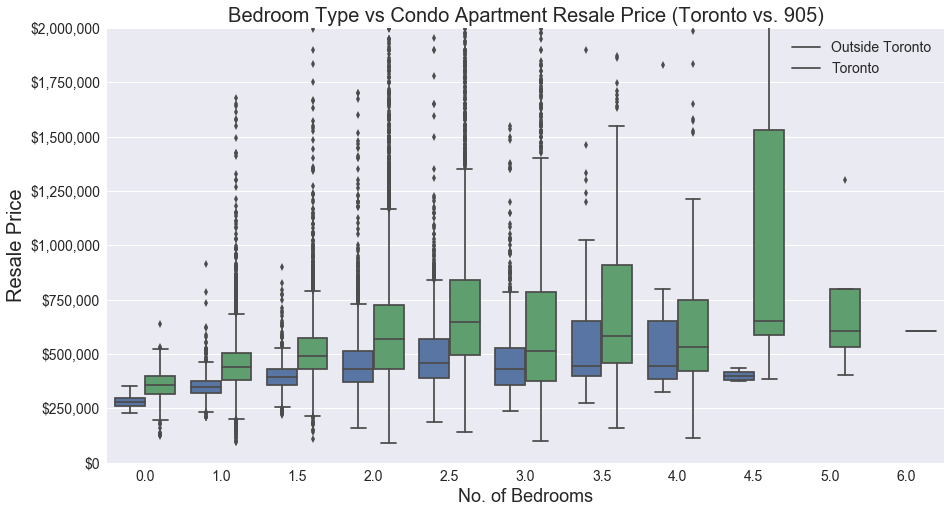

In [22]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x='Bedrooms', y='Sold Price', data = resales_df, hue = "toronto")

ax.tick_params(labelsize=14)
ax.set_ylabel(ylabel="Resale Price",fontsize = 20)
ax.set_xlabel(xlabel = "No. of Bedrooms", fontsize = 18)
ax.legend(labels = ["Outside Toronto", "Toronto"], fontsize = 14)

ax.set_ylim([0,2000000])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.title('Bedroom Type vs Condo Apartment Resale Price (Toronto vs. 905)', fontsize=20)
plt.show()

### 2.9 Baths

No point standardizing Baths because it is a discrete variable. We can however replace NaN with Median values.

In [23]:
resales_df.loc[resales_df['Bath'].isnull(), 'Bath'] = resales_df['Bath'].median()

### 2.10 Days on Market
Clean and standardize.

In [24]:
resales_df['Days on Market'].describe()

count   42675.0000
mean       14.7788
std        18.6044
min         0.0000
25%         4.0000
50%         8.0000
75%        19.0000
max       399.0000
Name: Days on Market, dtype: float64

There are 2 missing DOM values. We will replace with median, 8.0.


C:\Users\Fabienne\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


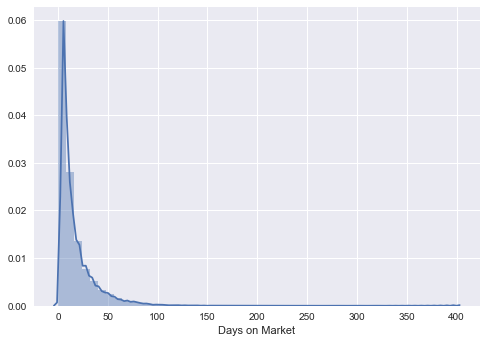

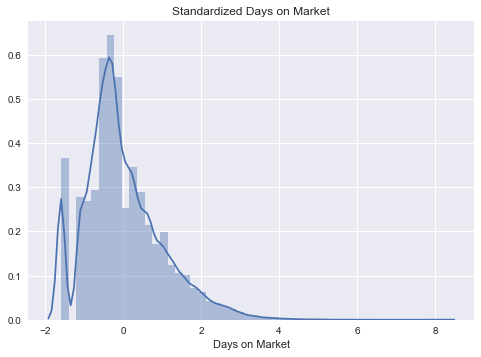

In [25]:
# Clean data where Days on Market is NaN. Replace the values with median.
print("There are {} missing DOM values. We will replace with median, {:,}.".format(sum(resales_df['Days on Market'].isnull()), resales_df['Days on Market'].median()))
resales_df.loc[resales_df['Days on Market'].isnull(), 'Days on Market'] = resales_df['Days on Market'].median()

# Quick exploration of Days on market shows distribution is skewed right by some outliers. 
sns.distplot(resales_df['Days on Market'])
plt.show()

# We will overcome this via standardization.
# Log transformation yields an irregular distribution so we use Square Root Transformation instead. 
resales_df['Days on Market'] = StandardScaler().fit_transform(np.sqrt(resales_df['Days on Market']).values.reshape(-1,1))
sns.distplot(resales_df['Days on Market'])
plt.title("Standardized Days on Market")
plt.show()

### 2.11. Nearest Higher-Order Transit Stop
Let's standardize distances to the nearest Higher-Order Transit stops.

C:\Users\Fabienne\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


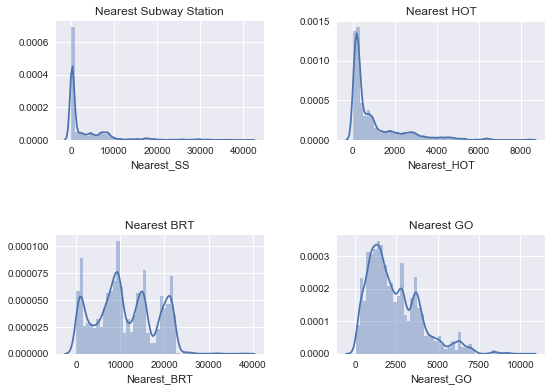

In [26]:
# Let's take a quick look at distribution
plt.figure(1)

plt.subplot(221)
sns.distplot(resales_df['Nearest_SS'])
plt.title('Nearest Subway Station')
plt.grid(True)

plt.subplot(222)
sns.distplot(resales_df['Nearest_HOT'])
plt.title('Nearest HOT')
plt.grid(True)

plt.subplot(223)
sns.distplot(resales_df['Nearest_BRT'])
plt.title('Nearest BRT')
plt.grid(True)

plt.subplot(224)
sns.distplot(resales_df['Nearest_GO'])
plt.title('Nearest GO')
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.8,
                    wspace=0.35)
plt.show()

C:\Users\Fabienne\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


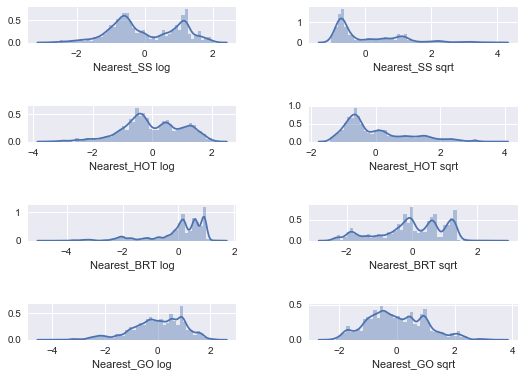

In [27]:
# Visualize whether Square Root or Log is best for standardizing the data
resales_df['Nearest_SS log'] = StandardScaler().fit_transform(np.log(resales_df['Nearest_SS']).values.reshape(-1,1))
resales_df['Nearest_SS sqrt'] = StandardScaler().fit_transform(np.sqrt(resales_df['Nearest_SS']).values.reshape(-1,1))
resales_df['Nearest_HOT log'] = StandardScaler().fit_transform(np.log(resales_df['Nearest_HOT']).values.reshape(-1,1))
resales_df['Nearest_HOT sqrt'] = StandardScaler().fit_transform(np.sqrt(resales_df['Nearest_HOT']).values.reshape(-1,1))
resales_df['Nearest_BRT log'] = StandardScaler().fit_transform(np.log(resales_df['Nearest_BRT']).values.reshape(-1,1))
resales_df['Nearest_BRT sqrt'] = StandardScaler().fit_transform(np.sqrt(resales_df['Nearest_BRT']).values.reshape(-1,1))
resales_df['Nearest_GO log'] = StandardScaler().fit_transform(np.log(resales_df['Nearest_GO']).values.reshape(-1,1))
resales_df['Nearest_GO sqrt'] = StandardScaler().fit_transform(np.sqrt(resales_df['Nearest_GO']).values.reshape(-1,1))

plt.clf()

# Let's take a quick look at distribution
plt.figure(1)

plt.subplot(421)
sns.distplot(resales_df['Nearest_SS log'])
plt.grid(True)
plt.subplot(422)
sns.distplot(resales_df['Nearest_SS sqrt'])
plt.grid(True)

plt.subplot(423)
sns.distplot(resales_df['Nearest_HOT log'])
plt.grid(True)
plt.subplot(424)
sns.distplot(resales_df['Nearest_HOT sqrt'])
plt.grid(True)

plt.subplot(425)
sns.distplot(resales_df['Nearest_BRT log'])
plt.grid(True)
plt.subplot(426)
sns.distplot(resales_df['Nearest_BRT sqrt'])
plt.grid(True)

plt.subplot(427)
sns.distplot(resales_df['Nearest_GO log'])
plt.grid(True)
plt.subplot(428)
sns.distplot(resales_df['Nearest_GO sqrt'])
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1.8,
                    wspace=0.35)
plt.show()

It would appear log transformations offer more consistency to our transformations. We'll use this method.

In [28]:
resales_df['Nearest_GO'] = resales_df['Nearest_GO log']
resales_df['Nearest_BRT'] = resales_df['Nearest_BRT log']
resales_df['Nearest_SS'] = resales_df['Nearest_SS log']
resales_df['Nearest_HOT'] = resales_df['Nearest_HOT log']

resales_df.drop(['Nearest_GO log', 'Nearest_GO sqrt','Nearest_BRT log','Nearest_BRT sqrt',
                       'Nearest_SS log','Nearest_SS sqrt', 'Nearest_HOT log','Nearest_HOT sqrt'], 
                axis = 1, inplace = True)

### 2.12. Parking (Binary Encoding)
1 for Yes parking, 0 for no parking.

In [29]:
resales_df['Parking'] = [1 if i == 'Yes' else 0 for i in resales_df['Parking']]

### 2.13. Lockers (Binary Encoding)

In [30]:
resales_df['Locker'] = [0 if i == 'No' or i == 'Common' else 1 for i in resales_df['Locker']]

### 2.14 Unit (Construct two new binary features: Is_TH, Is_PH)

From our **Units** field, we can infer additional information, such as whether it is a townhouse (while arguably a separate housing type, it's common practice for the real estate industry to include data on townhouses at the base of a condominium apartment in market analyses). We can also parse out of something is a penthouse. We'll create two new fields ("is_TH" and "is_PH") with binary encoding for this.

In [31]:
resales_df['is_TH'] = [1 if i == True else 0 for i in resales_df['Unit'].str.lower().str.contains('th')]
resales_df['is_PH'] = [1 if i == True else 0 for i in resales_df['Unit'].str.lower().str.contains('ph')]

# Drop unit column
resales_df.drop('Unit', axis = 1, inplace=True)

And that's it for cleaning and encoding! 

## 3. Modelling

### Split into Training and Testing Data

Now that our data is finally ready, we must split it into data our model can train on, and data for testing. We'll randomly split 80% of it for training and the remainig 20% for testing.

In [32]:
from sklearn.model_selection import train_test_split 

train, test = train_test_split(resales_df, test_size=0.2, random_state=0)
print("Total sample size = {:,}; training sample size = {:,}, testing sample size = {:,}.".format(\
     resales_df.shape[0],train.shape[0],test.shape[0]))

Total sample size = 42,677; training sample size = 34,141, testing sample size = 8,536.


In [33]:
df_train = train.loc[:,resales_df.columns]
X_train = df_train.drop(['Sold Price'], axis=1)
y_train = df_train.loc[:, ['Sold Price']]

df_test = test.loc[:,resales_df.columns]
X_test = df_test.drop(['Sold Price'], axis=1)
y_test = df_test.loc[:, ['Sold Price']]

### Choosing Our Model
We will test out three basic models to predict our data: Linear Regression, Random Forest, and Gradient Boosting.

### 1.) Linear Regression

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

# Create the regressor
linreg = LinearRegression()

# Fit the regressor to the training data
linreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = linreg.predict(X_test)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores_linreg = cross_val_score(linreg, X_train, y_train, cv=5)

print("R^2: {:.2f}".format(linreg.score(X_test, y_test)))

mae = abs(y_test - y_pred).mean().item()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Mean Absolute Error: {:.2f}".format(mae))
print("Root Mean Squared Error: {:.2f}".format(rmse))

print("Average 5-Fold CV Score: {:.5f}".format(np.mean(cv_scores_linreg)))
print(cv_scores_linreg)

R^2: 0.60
Mean Absolute Error: 112630.24
Root Mean Squared Error: 185461.19
Average 5-Fold CV Score: 0.59517
[0.60293903 0.59172345 0.56290829 0.59449235 0.62379104]


### 2.) Random Forest
We will use two forests here. One will be set to the default of 10 decision trees while the other will be set to 100 decision trees. While increasing the number of trees tends to improve the accuracy of our model, we run the risk of overfitting to the training data if we set this number too high. A high number of trees will also slow down the model. However, given the relatively small size of our dataset and number of features, 100 decision trees should be adequate for our predictor.

In [35]:
random_forest = RandomForestRegressor(n_estimators = 10, random_state = 0)

start = time.time()

random_forest.fit(X_train, y_train)

y_pred_rf = random_forest.predict(X_test)

print("Random Forest (10 (default) trees) R^2: {:.4f}".format(random_forest.score(X_test, y_test)))

mae_rf = abs(y_test.values.ravel() - y_pred_rf).mean().item()
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Mean Absolute Error: {:.2f}".format(mae_rf))
print("Root Mean Squared Error: {:.2f}".format(rmse_rf))

# Print the 5-fold cross-validation scores
cv_scores_rf = cross_val_score(random_forest, X_train, y_train.values.ravel(), cv=5)
print("Average 5-Fold CV Score: {:.4f}".format(np.mean(cv_scores_rf)))
print(cv_scores_rf)

print("\nTime elapsed: {:.2f} seconds".format(time.time() - start))

C:\Users\Fabienne\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Random Forest (10 (default) trees) R^2: 0.8947
Mean Absolute Error: 50019.37
Root Mean Squared Error: 95154.96
Average 5-Fold CV Score: 0.8389
[0.86282212 0.78101956 0.80838234 0.866611   0.87561959]

Time elapsed: 13.47 seconds


In [36]:
random_forest_100 = RandomForestRegressor(n_estimators = 100, random_state = 0)

start = time.time()
random_forest_100.fit(X_train, y_train.values.ravel())

y_pred_rf100 = random_forest_100.predict(X_test)

print("Random Forest (100 trees) R^2: {:.4f}".format(random_forest_100.score(X_test, y_test)))

mae_rf100 = abs(y_test.values.ravel() - y_pred_rf100).mean()
rmse_rf100 = np.sqrt(mean_squared_error(y_test, y_pred_rf100))
print("Mean Absolute Error: {:.2f}".format(mae_rf100))
print("Root Mean Squared Error: {:.2f}".format(rmse_rf100))

cv_scores_rf100 = cross_val_score(random_forest_100, X_train, y_train.values.ravel(), cv=5)
print("Average 5-Fold CV Score: {:.4f}".format(np.mean(cv_scores_rf100)))

print("\nTime elapsed: {:.1f} seconds".format(time.time() - start))

Random Forest (100 trees) R^2: 0.9029
Mean Absolute Error: 48114.75
Root Mean Squared Error: 91389.67
Average 5-Fold CV Score: 0.8536

Time elapsed: 146.3 seconds


### 3.) Gradient Boosting
Gradient Boosting is an ensemble method, meaning it is built using many weak learners (i.e. shallow decision trees). Unlike random forest, which builds trees on randomly selected features (thus the name), gradient boosting regressors is an iterative process where each tree is drawn depending on residual errors from the previous tree. There's a fantastic 2-minute explanation [here](https://www.youtube.com/watch?v=GM3CDQfQ4sw). This learning process tends to make Gradient Boosting a method favoured by many in the data science community.

Let's see how well it applies to our model...

In [37]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

start = time.time()

# R squared
gradientboost = ensemble.GradientBoostingRegressor()
gradientboost.fit(X_train, y_train.values.ravel()) 
print('Gradient Boosting R^2: {:.4f}'.format(gradientboost.score(X_test, y_test)))

# MAE and RMSE
y_pred_gb = gradientboost.predict(X_test)
gradientboost_mae = abs(y_pred_gb - y_test.values.ravel()).mean()
gradientboost_rmse = np.sqrt(mean_squared_error(y_pred_gb, y_test.values.ravel()))
print("Mean Absolute Error: {:.2f}".format(gradientboost_mae))
print('Gradient Boosting RMSE: {:.4f}'.format(gradientboost_rmse))

# 5-Fold cross-validation Score
cv_scores_gb = cross_val_score(gradientboost, X_train, y_train.values.ravel(), cv=5)
print("Average 5-Fold CV Score: {:.4f}".format(np.mean(cv_scores_gb)))
print("\nTime elapsed: {:.1f} seconds".format(time.time() - start))

Gradient Boosting R^2: 0.8472
Mean Absolute Error: 68268.35
Gradient Boosting RMSE: 114649.2841
Average 5-Fold CV Score: 0.8053

Time elapsed: 22.5 seconds


In [38]:
R2_ = [linreg.score(X_test,y_test), random_forest.score(X_test,y_test), random_forest_100.score(X_test, y_test), gradientboost.score(X_test, y_test)] 
MAE_ = ["${:,.0f}".format(x) for x in [mae, mae_rf, mae_rf100, gradientboost_mae]]
RMSE_ = ["${:,.0f}".format(x) for x in [rmse, rmse_rf, rmse_rf100, gradientboost_rmse]]
cv_5 = [np.mean(x) for x in [cv_scores_linreg, cv_scores_rf, cv_scores_rf100, cv_scores_gb]]

pd.DataFrame(index=['R2', 'Mean Absolute Error','Root Mean Squared Error','Avg 5-Fold Cross-Validation Score'], 
             columns = ["Linear Regr.", "Random Forest", "Random Forest 100", "Gradient Boost"], data = [R2_, MAE_, RMSE_, cv_5])

,Linear Regr.,Random Forest,Random Forest 100,Gradient Boost
R2,0.6000,0.8947,0.9029,0.8472
Mean Absolute Error,"$112,630","$50,019","$48,115","$68,268"
Root Mean Squared Error,"$185,461","$95,155","$91,390","$114,649"
Avg 5-Fold Cross-Validation Score,0.5952,0.8389,0.8536,0.8053


A side-by-side comparison of how the models perform shows that Random Forest set to 100 trees has the least margin of error for predicting prices.

### Improving Our Model
Feature importance is crucial to model optimization. Without getting lost in the technical details, __feature importance__ is a measure of how relevant the independent features are to explaining/predicting our target variable. In a nutshell, they measure the reduction in error in including the feature. 

Below, are the feature importances, per our three models, ranked by importance to our 'Random Forest with 100 Trees' model.

In [39]:
GB_results = pd.DataFrame(columns=['Features','GB Importance'], index = X_train.columns, data = list(zip(X_train.columns, gradientboost.feature_importances_)))
RF_results = pd.DataFrame(columns=['Features','RF Importance'], index = X_train.columns, data = list(zip(X_train.columns,random_forest.feature_importances_)))
RF100_results = pd.DataFrame(columns=['Features', 'RF100 Importance'], index = X_train.columns, data = list(zip(X_train.columns,random_forest_100.feature_importances_)))

importance_df = GB_results.drop('Features', axis=1).join(RF_results.drop('Features', axis=1), how='outer')
importance_df = importance_df.join(RF100_results.drop('Features', axis=1), how='outer')
importance_df.sort_values('RF100 Importance', ascending= False)

,GB Importance,RF Importance,RF100 Importance
Size_Range,0.3378,0.5132,0.5080
Nearest_SS,0.0764,0.1211,0.1214
Nearest_BRT,0.1458,0.1155,0.1167
Building_Age,0.1173,0.0657,0.0671
Bath,0.0546,0.0518,0.0449
Nearest_GO,0.0483,0.0314,0.0316
Days on Market,0.0165,0.0198,0.0253
Building_Units,0.0354,0.0213,0.0203
Bedrooms,0.0321,0.0135,0.0159
Nearest_HOT,0.0189,0.0133,0.0146


We can see from our Feature Importance table that unit size (Size Range) has the greatest impact on predicting price (0.51), followed by distance to Subway/Streetcar/BRT stop (0.12) and Building Age (0.07). Conversely, our model considers whether a listing is in Ajax, Oshawa, or Whitby as having virtually no importance on predicting price. Taking a step back, this is not to say municipality location is unimportant, per se - ceterus parabus, a condo listing in Oshawa would not be priced the same as if it were in Oakville. However, for our model, it has less influence in predicting price in our data, considering other features.

If we wanted to improve this model, one avenue would be to remove features with less importance. Perhaps we'll do that in a follow up post.

### Modelling Summary
We have tried three models: Linear Regression, Random Forest, and Gradient Boosting. Between the three and in terms of R Squared and RMSE, Random Forest performs the best for predicting our housing prices. 

Gradient Boosting is often preferred over Random Forest because of its iterative learning process (adjusting according to the errors of its predecessing models), however, it is prone to overfitting when data has lots of noise. This is the case with our data, scraped raw from a listings site and often with outliers (e.g. luxury units, problematic units, negotiation nuances). As such, Random Forest is a more accurate predictive model for this data.

Let's visualize how our chosen model, Random Forest with 100 trees, performs with its predicted target Y variables vs. actual target Y variables.

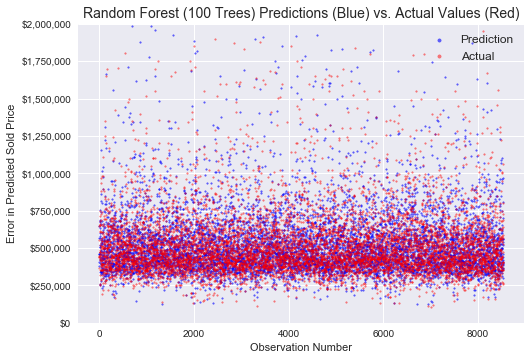

In [40]:
fig,ax = plt.subplots()
plt.scatter(x = range(len(y_pred_rf100)), y = y_pred_rf100, alpha = 0.6,  s = 3, c='b', label='Prediction')
plt.scatter(x = range(len(y_pred_rf100)), y = y_test.values, alpha = 0.5, s = 3, c='r', label='Actual')
plt.legend(fontsize=12, markerscale=2)
plt.ylim(0,2000000)
plt.title("Random Forest (100 Trees) Predictions (Blue) vs. Actual Values (Red)", fontsize = 14)
plt.ylabel("Error in Predicted Sold Price")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.xlabel("Observation Number")
plt.show()

## 4. Conclusion

With an R Squared value of 0.90, our chosen model of 100 trees typically predicts real estate prices within roughly $48,000 of the actual price - not bad at all! The next step would be to go into production and deploy this on a server...

But before we get too excited, it's important to point out the dynamic nature of the real estate market which would impact the real-life performance of our model. Out of curiosity, I quickly ran the model against roughly 3,800 active listings (on market as of October 31st 2018) and yielded the following results:

![title](2_Analysis/Model against Active.png)

Evidently, this model has a far lower success rate on more recent listings. Perhaps our training data was too old. Perhaps our predictor variables were not as accurate. There are a number of factors the inaccuracy could be due to and they all highlight the quickly evolving and nuanced nature of real estate demand and supply. But I'd argue figuring out the different variables and their impacts on the market is the fun part.

## Closing Points

Moving forward, we're seeing more datapoints permeate the real estate and real estate-adjacent industries, such as exact unit square footage (as opposed to just ranges) and [elevator inspection data](https://www.tssa.org/en/elevating-devices/elevating-devices---open-data.aspx) - which we can use to extrapolate other information about buildings and engineer more features from. Addtionally, we could build and join a database that rates developers and their building track record -- we know certain developers like Tridel are superior in their quality of building materials while others couldn't care less if their floorboards start peeling before building registration. We could also maybe calculate school ratings and distance to the closest school (although this would probably be more useful for predicting single-detached home prices). The possibilities are endless.

While our model works quite well, with more fine-tuning and feature-engineering, I am sure we can build a much more robust model that "understands" the real estate market much better. 

As usual, I'm happy to chat about ideas. Feel free to reach me on [LinkedIn](https://www.linkedin.com/in/fabiennechan/) or [Twitter](http://www.twitter.com/fabiennechan).